In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [17]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf

from datetime import datetime, timedelta
import importlib

from lucy.application.trading.exchange import Exchange
from lucy.model.interval import Interval
from lucy.application.trading.kraken_futures_api import FuturesApi
from lucy.application.trading.chart import chart

In [21]:
def chart(name: str, dfc: pd.DataFrame, signals_df: list[tuple[str, pd.DataFrame]] = None):  # type: ignore
    signals_df = signals_df or []
    num_signals = len(signals_df)
    top_height = 4
    subplot_height = 2 

    num_rows = num_signals + 2
    height = top_height + (subplot_height * num_signals)
    plt.figure(figsize=(20, height))

    ax1 = plt.subplot2grid((num_rows, 1), (0, 0), rowspan=2)
    ax1.plot(dfc)    
    ax1.legend(dfc.columns)
    ax1.set_title(name)

    i = 2
    for nm, ind in signals_df:
        ax2 = plt.subplot2grid((num_rows, 1), (i, 0), rowspan=1)
        ax2.plot(ind)
        plt.title(nm)
        plt.plot(ind)
        i += 1
    plt.tight_layout()
    plt.show()
    # path = '/mnt/c/lucy_charts/'
    # plt.savefig(f"{path}{name}.png")
    # plt.close()

In [9]:
def chart_title(pair: str, interval: Interval, action: str):
    now = datetime.now().strftime("%y.%m.%d_%H:%M:%S")
    return f"RsiCrossover_{pair}_{interval}_{action.upper()}_{now}"

In [28]:
pair = "pf_dotusd" #"ETHUSD" #"XBTUSD"
interval = Interval(1)
exch = Exchange()
df_org = exch.ohlc(pair, interval, 'trade')

In [38]:
df = df_org.copy()
fast_rsi_length = 14
slow_rsi_length = 28
rsi_level = 70

rsi_fast = f"RSI_{fast_rsi_length}"
rsi_slow = f"RSI_{slow_rsi_length}"

fast_ma_length = 50
slow_ma_length = 200
ma_type = "sma"

# Column names
# - Moving Averages
fastMa = f"{ma_type.upper()}_{fast_ma_length}"
slowMa = f"{ma_type.upper()}_{slow_ma_length}"

strategy = ta.Strategy(
    name="strategy_BBbreakout",
    ta=[{
        "close":    'close',
        "kind":     'rsi', 
        "length":   fast_rsi_length
    }, {
        "close":    'close',
        "kind":     'rsi', 
        "length":   slow_rsi_length
    }, {
        "close":    'close',
        "kind":     ma_type, 
        "length":   fast_ma_length
    }]
)
df.ta.strategy(strategy)

df["rsi_cross_up"] = (df[rsi_fast] > df[rsi_slow]) & (df[rsi_fast].shift() < df[rsi_slow].shift())
df["rsi_cross_down"] = (df[rsi_fast] < df[rsi_slow]) & (df[rsi_fast].shift() > df[rsi_fast].shift())
df["close_above_fast_ma"] = df["close"] > df[fastMa]
df["entry_signal"] = df["rsi_cross_up"] & (df[rsi_fast] < rsi_level) & df["close_above_fast_ma"]
df.tail()

,open,high,low,close,volume,RSI_14,RSI_28,SMA_50,rsi_cross_up,rsi_cross_down,close_above_fast_ma,entry_signal
time,,,,,,,,,,,,
2023-08-24 00:39:00,4.499,4.499,4.499,4.499,0.0,99.037319,93.099284,4.48946,False,False,True,False
2023-08-24 00:40:00,4.499,4.499,4.499,4.499,0.0,99.037319,93.099284,4.48966,False,False,True,False
2023-08-24 00:41:00,4.499,4.499,4.499,4.499,0.0,99.037319,93.099284,4.48986,False,False,True,False
2023-08-24 00:42:00,4.499,4.499,4.499,4.499,0.0,99.037319,93.099284,4.49006,False,False,True,False
2023-08-24 00:43:00,4.499,4.499,4.499,4.499,0.0,99.037319,93.099284,4.49026,False,False,True,False


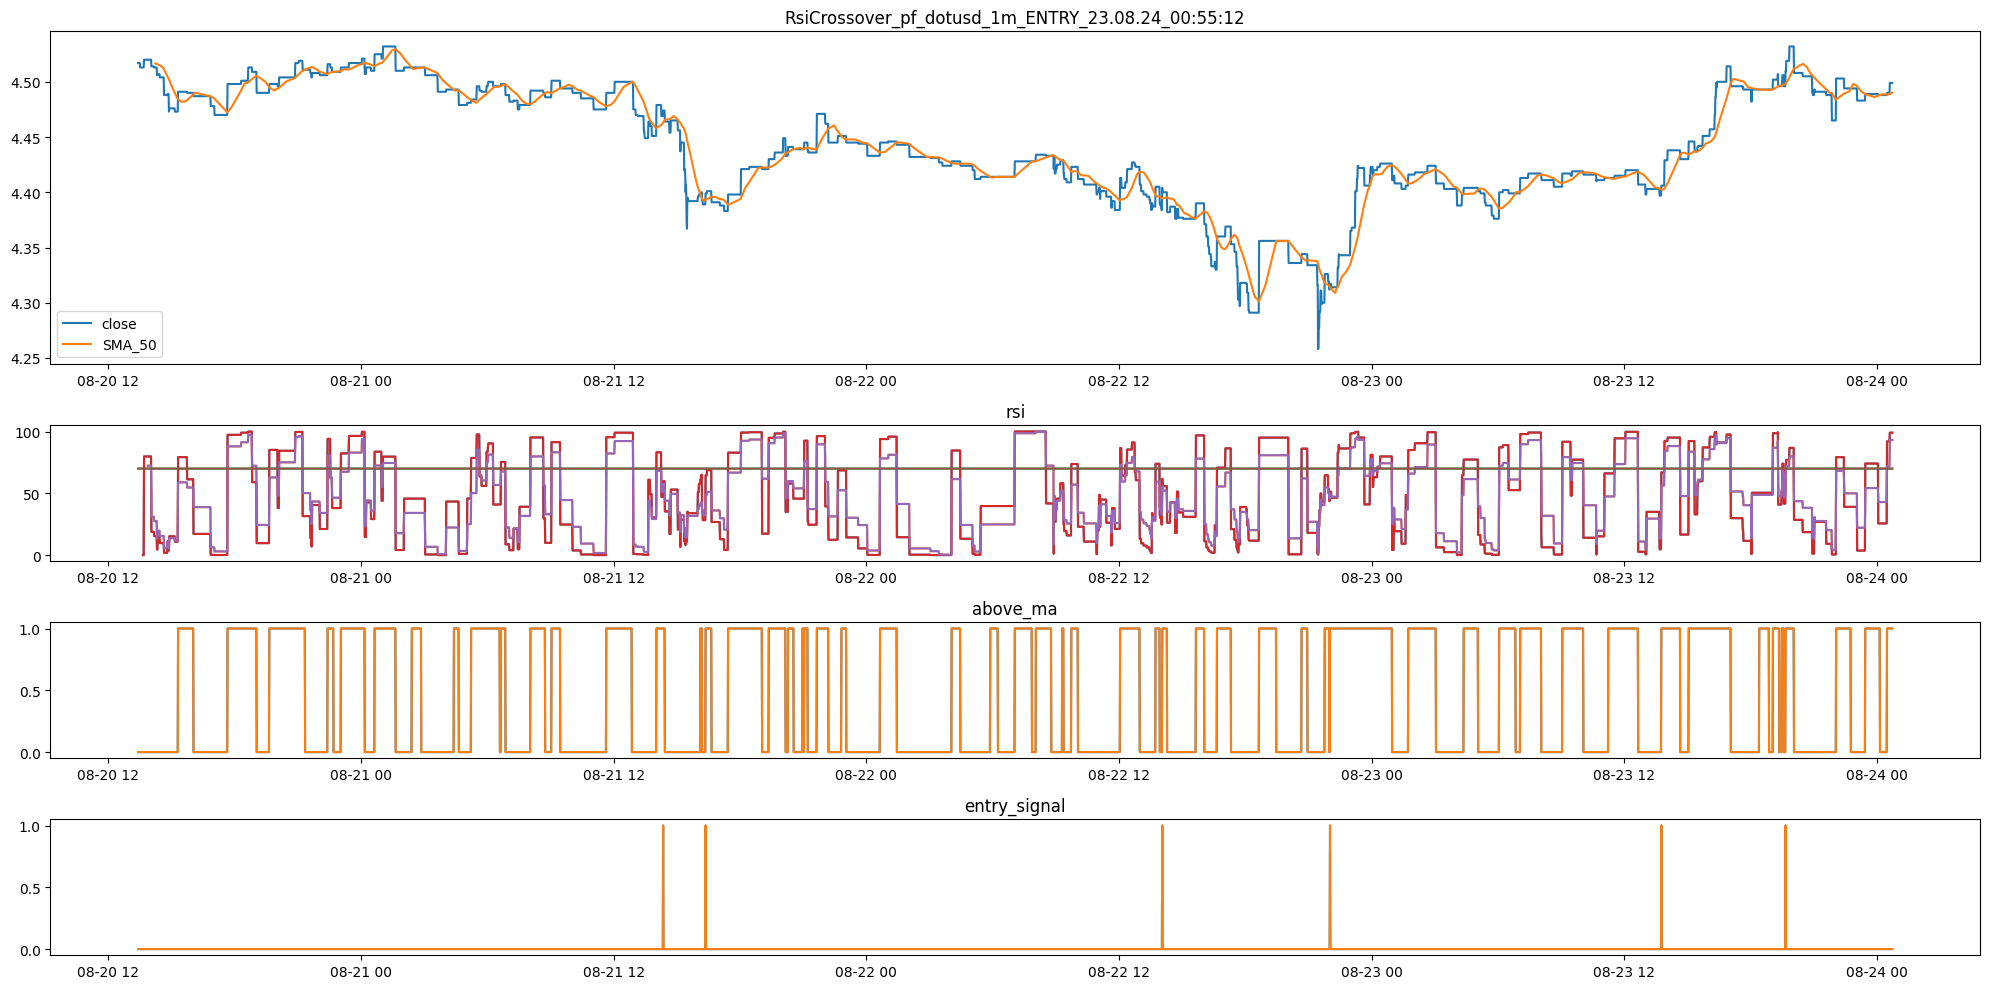

In [40]:
chart_data      = df[['close', fastMa]]

entry_signal    = ('entry_signal', df[['entry_signal']] )
df['rsi_level'] = rsi_level
rsi    = ('rsi', df[[rsi_fast, rsi_slow, 'rsi_level']] )
above_ma    = ('above_ma', df[['close_above_fast_ma']] )

signals         = [rsi, above_ma, entry_signal]
name            = chart_title(pair, interval, 'entry')
chart(name, chart_data, signals)